In [1]:
from src import *

## Goal

The goal of this notebook is to do create paths (voxel level) to match pairs of regions with highest connectivity paths

## Description
Generate paths according to the functional connectivity of pairs of regions. 
- E.g using highest sum of energy (energy being positive correlation)

Generate usual bundle paths prior to optimization and prepare functional connectivity information.

In [2]:
path2probatlas='../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale1.h5'
path2restdata='../atlas_data/rstfMRI_eg/rst_fmri_moviedata/'
region_of_interest=['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']

normalizing=False
regularizer=0 
norm='L2'
weigthpath='./'
voxelbundlepath='./'
inpaintpath='./'

In [3]:
# 1. Load the probabilistic atlas bundles
connFilename = path2probatlas
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
gmregions_names = hf.get('header').get('gmregions')[()]
bundle_affine = np.array(hf.get('header').get('affine'))[()]
nb_regions = len(gmregions_names)

# isolating region of interest that we want to compute the connectivity inpainting from
index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
                    for r in region_of_interest]


# 2. Load the rest fmri in MNI space volumes
# - Compute group rest timecourse at volume level in MNI
rest_runs = os.listdir(path2restdata)
rst_vols = [nib.load(path2restdata+'{}'.format(run)) for run in rest_runs]

rest_affine = rst_vols[0].affine
ftimecourses = [rst.get_fdata() for rst in rst_vols]
ftimecourses = np.asarray(ftimecourses)
ftimecourse = ftimecourses.mean(axis=0)
vdim = ftimecourse.shape[:3]
rst_vol = nib.Nifti1Image(ftimecourse, affine=rest_affine)

# 3. Extracting average timecourse and match voxel from probabilistic bundles with rest data
# - Transform the voxels to coordinates
# - Match the coordinates i.e the voxels to a given label
# - Obtain an mapping of a voxel to the parcels
labels_vol = np.zeros(rst_vol.shape[:3])
for x in tqdm(range(rst_vol.shape[0])):
    for y in range(rst_vol.shape[1]):
        for z in range(rst_vol.shape[2]):
            # Find the MNI coordinates of the voxel (x, y, z)
            spatial_coord = np.array(image.coord_transform(x, y, z, rst_vol.affine))
            labels_vol[x,y,z] = np.argmin(np.sum((centers - spatial_coord) ** 2, axis=1))
# Atlas averaging timecourses
avg_tc = np.zeros((centers.shape[0], rst_vol.shape[-1]))
for t in tqdm(range(rst_vol.shape[-1])):
    tmp = rst_vol.get_fdata()[:,:,:,t]
    for k in range(centers.shape[0]):
        indexes = (labels_vol == k)
        nonzero = tmp[indexes][(tmp[indexes] != 0)]
        avg_tc[k,t] = nonzero.mean()

# 4. Compute FC of atlased timecourses
corr_mat = np.zeros((avg_tc.shape[0],avg_tc.shape[0]))
for k in range(avg_tc.shape[0]):
    corr_mat[k] = nta.SeedCorrelationAnalyzer(avg_tc[k], avg_tc).corrcoef

# 5. Compute the Bundle matrix that we use to regress
thresh_subjapp = int(np.ceil(nsubject * 0.3)) # consider bundles that appaear at least in 30 % of the subjects    
# Generating the X samples and the y samples
# - Careful as well to remove the auto-correlation in the diagonal
# - Raster scan parsing meaning that it is the activity of (R0,R1) -> (R0,R2) -> (R0,R3) etc...
# Define matrix of end points on cortex
X = []
bundles_labels = []
pairs = np.zeros((nb_regions, nb_regions))
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))
        pairs[i-1,j-1] = 1.0
        vec = np.zeros(nb_regions)
        vec[i-1] = 1.0
        vec[j-1] = 1.0
        X.append(vec)
X = np.asarray(X)

consistency_view = get_aggprop(hf, 'consistency')
scale = (np.array([consistency_view[p[0]-1,p[1]-1]/nsubject for p in bundles_labels])) ** 2

100%|██████████| 95/95 [00:30<00:00,  3.16it/s]


In [9]:
trans_affine = np.matmul(np.linalg.inv(rest_affine), bundle_affine)
fmri_coords = []
for k in tqdm(range(len(bundles_labels))):
    i,j = bundles_labels[k]
    streamline = get_bundles_betweenreg(hf, i,j)
    streamline = streamline[streamline[:,3] >= thresh_subjapp]

    # Transform voxel indexes of a volume to voxel index of another volume
    volcoords_interest = volcoord2mnicoord(streamline[:,[0,1,2]], trans_affine).astype(int)
    fmri_coords.append(volcoords_interest)

100%|██████████| 1449/1449 [00:30<00:00, 46.79it/s] 


In [135]:
t_index_bundle = []
tidx = 18 # arbitrary region linked to pcc
for k in range(len(bundles_labels)):
    a,b = bundles_labels[k]
    cond1 = (a in index_of_interest) or (b in index_of_interest)
    cond2 = (a==tidx) or (b==tidx)
    if cond1 and cond2:
        t_index_bundle.append(k)
t_index_bundle = np.asarray(t_index_bundle)

fmri_coords_t = [fmri_coords[t_index_bundle[k]] for k in range(len(t_index_bundle))]
bundles_labels_t = [bundles_labels[t_index_bundle[k]] for k in range(len(t_index_bundle))]

## Wrong region seed connectivity
y vector of optimization is correlation with another region (not standard PCC) and regenerate to see difference of reconstruction and weightings

In [56]:
ycorrect = corr_mat[index_of_interest].mean(axis=0)
widx = 48
ywrong = corr_mat[widx]
print(f'Region of comparison for seed conn {gmregions_names[widx]}')

Region of comparison for seed conn b'ctx-lh-parsorbitalis'


In [52]:
lcorrect = optimize_lreg(X, ycorrect, scale, norm=norm, verbose=True)
lwrong = optimize_lreg(X, ywrong, scale, norm=norm, verbose=True)

100%|██████████| 1000/1000 [00:00<00:00, 2262.99it/s]


Losses are decomposed into generic loss=6.475376608250372e-07 and regularizer loss=0.0002532474172767252


100%|██████████| 1000/1000 [00:00<00:00, 2283.36it/s]

Losses are decomposed into generic loss=6.603352176171029e-07 and regularizer loss=0.00023261514434125274


In [53]:
wm_correct, _ = interpolate_connectivity(fmri_coords, bundles_labels, lcorrect, 
                                                   corr_mat, vdim, normalizing=normalizing)
wm_wrong, _ = interpolate_connectivity(fmri_coords, bundles_labels, lwrong, 
                                                   corr_mat, vdim, normalizing=normalizing)

100%|██████████| 1449/1449 [00:14<00:00, 103.50it/s]


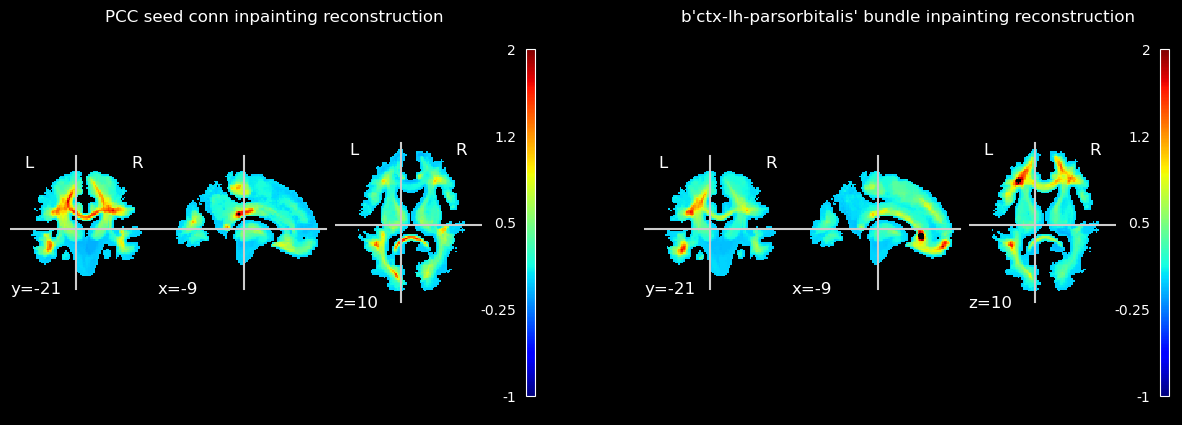

In [55]:
cmap = mpl.colormaps.get_cmap('jet')
cmap.set_extremes(under='black', over='black')
fig, ax = plt.subplots(1,2, figsize=(15,5), facecolor='black')
plot_epi(nib.Nifti1Image(wm_correct, affine=rest_affine),colorbar=True, cut_coords=(-9,-21,10), 
         cmap=cmap, vmin=-1, vmax=2, axes=ax[0])
ax[0].set_title('PCC seed conn inpainting reconstruction', color='white')

plot_epi(nib.Nifti1Image(wm_wrong, affine=rest_affine),colorbar=True, cut_coords=(-9,-21,10), 
         cmap=cmap, vmin=-1, vmax=2, axes=ax[1])
ax[1].set_title(f'{str(gmregions_names[widx])} bundle inpainting reconstruction', color='white')
plt.show()

## Perturbation of y
Wiggle y vector of optimization and regenerate to see stability of reconstruction and weightings

In [ ]:
boundcorr = lambda x: (x >= 1).astype(float) + ((x<=1) & (x>=-1)) * x + (x <= -1).astype(float) * (-1)

In [118]:
np.random.seed(99)
ycorrect = corr_mat[index_of_interest].mean(axis=0)
sigmas = [0.01, 0.05 , 0.1, 0.25, 0.5, 1]
noises = [np.random.normal(scale=s, size = ycorrect.shape) for s in sigmas]
snrs = [10*np.log10(np.mean(ycorrect**2) / np.mean(noise**2)) for noise in noises]
noises_Y = np.array([boundcorr(ycorrect + noise) for noise in noises])

In [119]:
lcorrect = optimize_lreg(X, ycorrect, scale, norm=norm, verbose=True)
lnoises = [optimize_lreg(X, ywrong, scale, norm=norm, verbose=True) for ywrong in noises_Y] 

100%|██████████| 1000/1000 [00:00<00:00, 2264.70it/s]


Losses are decomposed into generic loss=6.475376608250372e-07 and regularizer loss=0.0002532474172767252


100%|██████████| 1000/1000 [00:00<00:00, 2317.12it/s]


Losses are decomposed into generic loss=6.480409524556308e-07 and regularizer loss=0.0002540724817663431


100%|██████████| 1000/1000 [00:00<00:00, 2312.41it/s]


Losses are decomposed into generic loss=6.045555096534372e-07 and regularizer loss=0.0002538567059673369


100%|██████████| 1000/1000 [00:00<00:00, 2205.88it/s]


Losses are decomposed into generic loss=7.137983857319341e-07 and regularizer loss=0.00027648021932691336


100%|██████████| 1000/1000 [00:00<00:00, 2194.07it/s]


Losses are decomposed into generic loss=2.1419468794192653e-06 and regularizer loss=0.0005309334374032915


100%|██████████| 1000/1000 [00:00<00:00, 2336.57it/s]


Losses are decomposed into generic loss=4.605752565112198e-06 and regularizer loss=0.0008691618568263948


100%|██████████| 1000/1000 [00:00<00:00, 2269.48it/s]

Losses are decomposed into generic loss=9.255248187400866e-06 and regularizer loss=0.0018188862595707178


In [120]:
wm_correct, _ = interpolate_connectivity(fmri_coords, bundles_labels, lcorrect, 
                                                   corr_mat, vdim, normalizing=normalizing)
wm_noises = [interpolate_connectivity(fmri_coords, bundles_labels, lwrong, corr_mat, vdim, normalizing=normalizing)[0] for lwrong in lnoises]

100%|██████████| 1449/1449 [00:14<00:00, 101.76it/s]


Text(0.5, 1.0, 'PCC seed conn inpainting reconstruction')

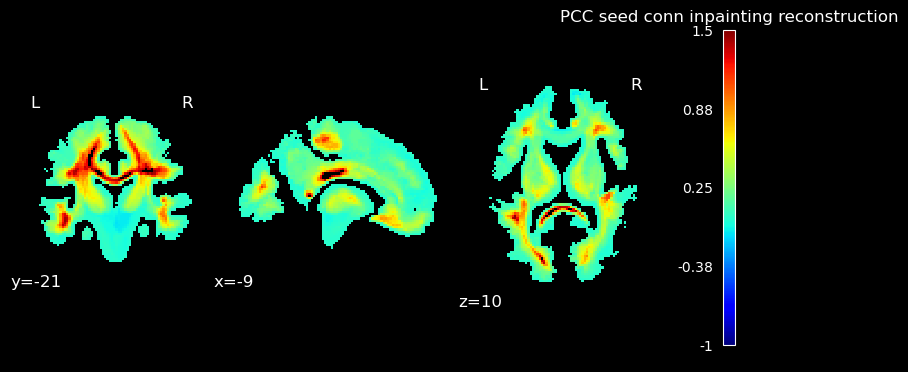

In [126]:
cmap = mpl.colormaps.get_cmap('jet')
cmap.set_extremes(under='black', over='black')
plot_epi(nib.Nifti1Image(wm_correct, affine=rest_affine),colorbar=True, cut_coords=(-9,-21,10), 
         cmap=cmap, vmin=-1, vmax=1.5, draw_cross=False)
plt.title('PCC seed conn inpainting reconstruction', color='white')

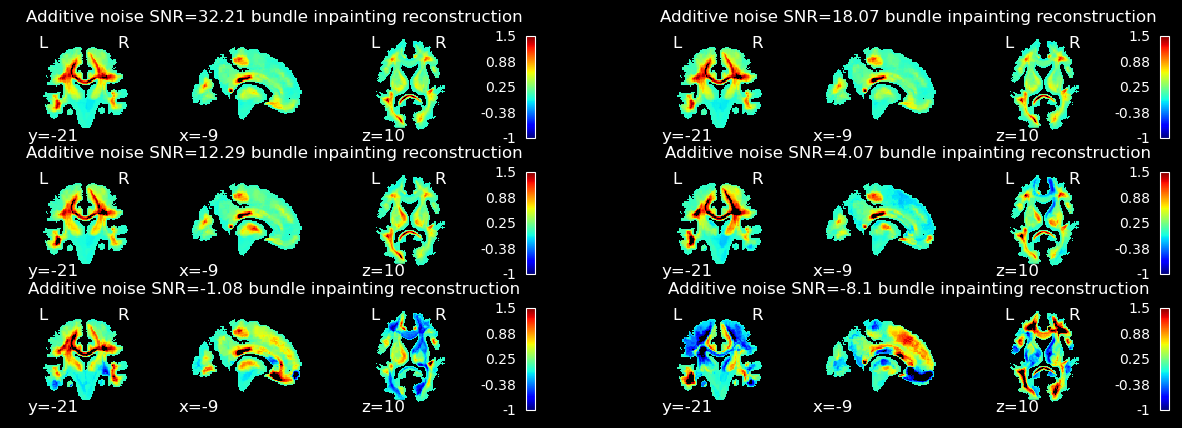

In [127]:
fig, ax = plt.subplots(3,2, figsize=(15,5), facecolor='black')

for k in range(6):
    r,c = k//2, k%2
    plot_epi(nib.Nifti1Image(wm_noises[k], affine=rest_affine),colorbar=True, cut_coords=(-9,-21,10), 
         cmap=cmap, vmin=-1, vmax=1.5, axes=ax[r,c], draw_cross=False)
    ax[r,c].set_title(f'Additive noise SNR={np.round(snrs[k],2)} bundle inpainting reconstruction', color='white')
plt.show()

Reconstruct bundle only weighting path and see variation of path

In [136]:
wm_bundle, _ = interpolate_connectivity(fmri_coords_t, bundles_labels_t, lcorrect[t_index_bundle], 
                                                corr_mat, vdim, normalizing=normalizing)

100%|██████████| 1/1 [00:00<00:00, 3938.31it/s]


In [137]:
wm_noises_bundle = [interpolate_connectivity(fmri_coords_t, bundles_labels_t, lwrong[t_index_bundle], corr_mat, vdim, normalizing=normalizing)[0] for lwrong in lnoises] 

100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]


In [158]:
lcorrect[t_index_bundle] ,lnoises[0][t_index_bundle], lnoises[1][t_index_bundle], lnoises[2][t_index_bundle], lnoises[3][t_index_bundle], lnoises[4][t_index_bundle]

(array([0.01943058], dtype=float32),
 array([0.01930119], dtype=float32),
 array([0.02128018], dtype=float32),
 array([0.01613112], dtype=float32),
 array([-0.00351961], dtype=float32),
 array([0.03367065], dtype=float32))

In [140]:
def displayvol2computevol(vol):
    outlier = vol[0,0]
    ret = deepcopy(vol)
    ret[ret==outlier] = 0
    return ret

In [148]:
wm_ns = [displayvol2computevol(wm_noises_bundle[k]) for k in range(len(wm_noises_bundle))]

In [149]:
wm_c = displayvol2computevol(wm_bundle)

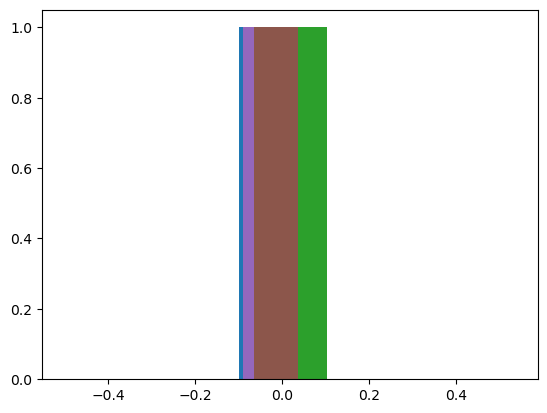

In [160]:
for k in range(6):
    tmp = np.abs(wm_ns[k] - wm_c).flatten()
    tmp[tmp==0]= np.nan
    plt.hist(tmp)

## t-stats: Weights - Residuals 

In [4]:
# loading weights 
thresh_subjapp = 20
trained_weights = load(f'./resources/weights_regressors/seedPCC_HCP_bundlediv{thresh_subjapp}.pkl')

coefs = trained_weights['coefs_ridge']
coefs_lasso = trained_weights['coefs_lasso']
cL2_reg = trained_weights['cl2_reg']
cL1_reg = trained_weights['cl1_reg']
cPL2_reg = trained_weights['cpl2_reg']
lL2_reg = trained_weights['lL2_reg']
lL1_reg = trained_weights['lL1_reg']
lPL2_reg = trained_weights['lPL2_reg']
sL2_reg = trained_weights['sL2_reg']
sL1_reg = trained_weights['sL1_reg']
sPL2_reg = trained_weights['sPL2_reg']

In [66]:
# Choose and Set weights 
w = torch.Tensor(trained_weights['cl2_reg'])
modelshape = w.shape[0]
lreg = nn.Sequential(
        nn.Linear(modelshape, 1),)

lreg[0].weight = nn.parameter.Parameter(torch.Tensor(w[None]))

In [67]:
# compute residuals of the original y vector
y = corr_mat[index_of_interest].mean(axis=0)
pred = lreg(torch.Tensor(X).T).flatten().detach()

Use the usual t-statistics for glm : 

contrast vector $c$, weight vector $\beta$, design matrix $X$, residuals $e$

$$t=\frac{c^T\beta}{\sqrt{\text{Var}(e)c^T(X^TX)^{-1}c}} $$

In [102]:
from scipy import stats
def t_stats_reg(XXinv,c,w,residuals,df):
    """
    Compute t stats of regression model and 2-tail associated pvalue
    """
    num = c.T @ w
    den = np.sqrt(np.std(residuals) * c.T @ XXinv @ c)
    tstat = num / den
    pval = stats.t.sf(np.abs(tstat), df)*2
    return pval, tstat

def design_variance(X, XXinv=None, which_predictor=1):
    ''' Returns the design variance of a predictor (or contrast) in X.
    
    Parameters
    ----------
    X : numpy array
        Array of shape (N, P)
    which_predictor : int or list/array
        The index of the predictor you want the design var from.
        Note that 0 refers to the intercept!
        Alternatively, "which_predictor" can be a contrast-vector
        (which will be discussed later this lab).
        
    Returns
    -------
    des_var : float
        Design variance of the specified predictor/contrast from X.
    '''
    
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0
    
    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    if XXinv is None:
        des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    else:
        des_var = c.dot(XXinv).dot(c.T)
    return des_var

In [108]:
N = y.size
P = X.shape[0]
df = (N - P)
sigma_hat = np.sum((zscore(y) - np.array(zscore(pred))) ** 2) / df

w = np.array(torch.Tensor(trained_weights['cl2_reg']))
w_pvals = np.zeros_like(w)
w_tstat = np.zeros_like(w)

uuinv = np.linalg.inv(X.dot(X.T))
for k in tqdm(range(w.shape[0])):

    design_variance_weight = design_variance(X.T, which_predictor=k, XXinv=uuinv)

    # t-stats
    t_meter = w[k] / np.sqrt(sigma_hat * design_variance_weight)

    # multiply by two to create a two-tailed p-value
    p_values = stats.t.sf(np.abs(t), df) * 2 

    w_pvals[k] = p_values
    w_tstat[k] = t_meter

  0%|          | 0/1449 [00:00<?, ?it/s]/var/folders/9t/60tqjhtx2h55525lstv8nsc40000gn/T/ipykernel_10377/3235681785.py:16: RuntimeWarning: invalid value encountered in sqrt
  t_meter = w[k] / np.sqrt(sigma_hat * design_variance_weight)
100%|██████████| 1449/1449 [02:25<00:00,  9.94it/s]


In [109]:
w_tstat

array([           nan,            nan,            nan, ...,
                  nan, -1.6049292e-09, -1.1680897e-09], dtype=float32)

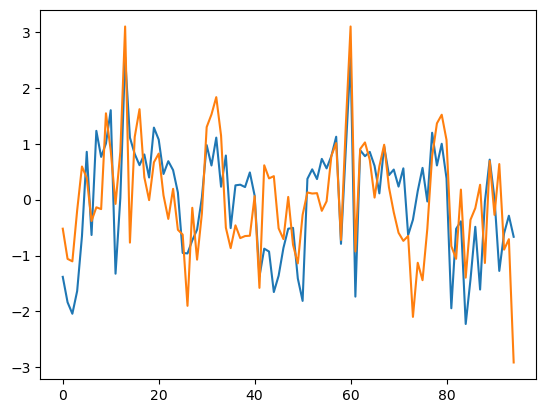

In [64]:
plt.plot(zscore(pred))
plt.plot(zscore(y))